In [0]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
#from nst_utils import *
import numpy as np
import tensorflow as tf

%matplotlib inline

In [0]:
content_directory = "drive/Computer Vision_Neural Styler/Deadpool.jpg"
style_directory = "drive/Computer Vision_Neural Styler/Green.jpg"
output_image_dir = "drive/Computer Vision_Neural Styler/Output_images_6/"
pretrained_model_dir = "drive/Computer Vision_Neural Styler" + "/" + "imagenet-vgg-verydeep-19.mat"

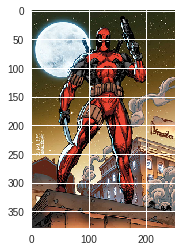

In [7]:
cont_img = scipy.misc.imread(content_directory)
imshow(cont_img)

In [8]:
print('Content Image shape:', cont_img.shape)

Content Image shape: (379, 250, 4)


In [0]:
def cost_of_content(C_dim, G_dim):
  m, n_H, n_W, n_C = G_dim.get_shape().as_list()
  C_dim_changed= tf.transpose(tf.reshape(C_dim, [-1]))
  G_dim_changed = tf.transpose(tf.reshape(G_dim, [-1]))
  
  content_cost = tf.reduce_sum((C_dim_changed - G_dim_changed)**2) / (4 * n_H * n_W * n_C)
  return content_cost

In [10]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    C_dim_changed = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    G_dim_changed = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    content_cost = cost_of_content(C_dim_changed, G_dim_changed)
    print("Cost of Content is " + str(content_cost.eval()))

Cost of Content is 6.7655935


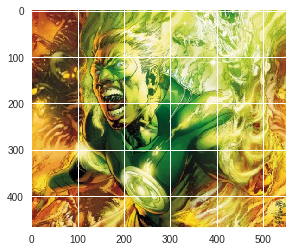

In [11]:
style_image = scipy.misc.imread(style_directory)
imshow(style_image)

In [12]:
print('Style image shape:', style_image.shape)

Style image shape: (469, 550, 3)


In [0]:
def cost_of_style_layer(S_dim, G_dim):
  m, n_H, n_W, n_C = G_dim.get_shape().as_list()
  S_dim = tf.reshape(S_dim, [n_H*n_W, n_C])
  G_dim = tf.reshape(G_dim, [n_H*n_W, n_C])
  
  GS = tf.matmul(tf.transpose(S_dim), S_dim)
  GG = tf.matmul(tf.transpose(G_dim), G_dim)
  
  Style_cost = tf.reduce_sum((GS - GG)**2) / (4 * n_C**2 * (n_W * n_H)**2)
  
  return Style_cost

In [14]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    S_dim = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    G_dim = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    Style_cost = cost_of_style_layer(S_dim, G_dim)
    
    print("Cost of Style is " + str(Style_cost.eval()))

Cost of Style is 9.190278


In [0]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [0]:
def cost_of_style(model, STYLE_LAYERS):
  J=0
  for layer, value in STYLE_LAYERS:
    ip_layer = model[layer]
    S_dim = sess.run(ip_layer)
    G_dim = ip_layer
    cost_of_style_lyr = cost_of_style_layer(S_dim, G_dim)
    J= J + value * cost_of_style_lyr
    
  return J
    

In [17]:
alpha = 8 
beta = 40
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    content_cost = np.random.randn()    
    J = np.random.randn()
    J_tot = alpha * content_cost + beta * J
    print("Total content + style cost is  = " + str(J_tot))

Total content + style cost is  = 31.769421807922125


In [0]:
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

In [0]:
import cv2
def resize(img_dir):
  
  img = cv2.imread(img_dir)
  img = cv2.resize(img,dsize=(400,300))
  out = np.array(img)
  return out

In [20]:
cont_img = resize(content_directory)
style_img = resize(style_directory)
print(cont_img.shape)
print(style_img.shape)

(300, 400, 3)
(300, 400, 3)


In [0]:
def reshape_and_normalize_image(image):
    # Reshape image to mach expected input of VGG19
    image = np.reshape(image, ((1,) + image.shape))
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    # Substract the mean to match the expected input of VGG19
    image = image - MEANS
    
    return image

In [0]:
cont_img=reshape_and_normalize_image(cont_img)

In [23]:
print(cont_img.shape)

(1, 300, 400, 3)


In [24]:
style_image = reshape_and_normalize_image(style_img)
print(style_image.shape)

(1, 300, 400, 3)


In [0]:
def generate_noise_image(cont_img, noise_ratio = 0.6):
    noise_image = np.random.uniform(-20, 20, (1, 300, 400, 3)).astype('float32')
    input_image = noise_image * noise_ratio + cont_img * (1 - noise_ratio)
    
    return input_image

In [0]:
noisy_content__image = generate_noise_image(cont_img)


In [0]:
def Load_vgg_model(path):
    vgg = scipy.io.loadmat(path)

    vgg_layers = vgg['layers']
    
    def _weights(layer, expected_layer_name):
        
        weight_bias = vgg_layers[0][layer][0][0][2]
        W = weight_bias[0][0]
        b = weight_bias[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        return W, b

    def _relu(conv2d_layer):
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

   
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, 300, 400, 3)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    
    return graph


In [0]:
model = Load_vgg_model(pretrained_model_dir)

In [0]:
sess.run(model['input'].assign(cont_img))
output = model['conv4_3']
C_dim = sess.run(output)
G_dim = output
Final_content_cost = cost_of_content(C_dim, G_dim)

In [0]:
sess.run(model['input'].assign(style_image))
Final_cost_style= cost_of_style(model, STYLE_LAYERS)

In [0]:
alpha = 20 
beta = 30
Final_total_cost = alpha * Final_content_cost + beta * Final_cost_style

In [0]:
optimizer = tf.train.AdamOptimizer(0.5)

In [0]:
train_step = optimizer.minimize(Final_total_cost)

In [0]:
def save_image(path, image):
    
    # Un-normalize the image so that it looks good
    image = image + np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    
    # Clip and Save the image
    image = np.clip(image[0], 0, 255).astype('uint8')
    scipy.misc.imsave(path, image)

In [0]:
def Art_neural_model(sess, ip):
  iter = 2000
  sess.run(tf.global_variables_initializer())
  sess.run(model['input'].assign(ip))
  
  for k in range(iter):
    dk = sess.run(train_step)
    generated_image = sess.run(model['input'])
    
    if k%100 == 0:
      
      a,b,c = sess.run([Final_total_cost, Final_content_cost, Final_cost_style])
      print("Iteration number: " + str(k) + " :")
      print("Total cost after these iterations = " + str(a))
      print("content cost after these iterations= " + str(b))
      print("style cost after these iterations= " + str(c))
      save_image(output_image_dir + str(k) + ".png", generated_image)

      
  save_image(output_image_dir+'/'+'Final_generated_image.jpg', generated_image)
  return generated_image

In [36]:
Art_neural_model(sess,noisy_content__image)

Iteration number: 0 :
Total cost after these iterations = 19150465000.0
content cost after these iterations= 4559.633
style cost after these iterations= 638345700.0
Iteration number: 100 :
Total cost after these iterations = 1553322200.0
content cost after these iterations= 8558.29
style cost after these iterations= 51771704.0
Iteration number: 200 :
Total cost after these iterations = 616703500.0
content cost after these iterations= 9286.342
style cost after these iterations= 20550592.0
Iteration number: 300 :
Total cost after these iterations = 382221120.0
content cost after these iterations= 9587.645
style cost after these iterations= 12734313.0
Iteration number: 400 :
Total cost after these iterations = 265546080.0
content cost after these iterations= 9841.308
style cost after these iterations= 8844975.0
Iteration number: 500 :
Total cost after these iterations = 193451470.0
content cost after these iterations= 10062.949
style cost after these iterations= 6441673.5
Iteration number

array([[[[ -30.467806 ,  -39.001022 ,  -10.462537 ],
         [ -53.742077 ,  -55.460297 , -118.07169  ],
         [ -90.01758  ,  -42.3311   ,  -31.774616 ],
         ...,
         [ -63.505833 ,  -59.667336 ,  -31.35586  ],
         [ -83.71975  ,  -51.89839  , -185.52179  ],
         [ -68.34331  ,  -68.71208  ,  -92.811005 ]],

        [[ -70.72339  ,  -62.7815   ,  -83.58585  ],
         [ -75.5782   ,  -45.24441  ,  -53.21999  ],
         [ -82.33038  ,  -37.60445  ,   39.002598 ],
         ...,
         [ -87.96739  ,  -46.369858 ,  -18.89513  ],
         [ -86.305305 ,  -50.377953 ,  -89.49467  ],
         [-105.40438  ,  -44.002853 ,  -94.78533  ]],

        [[ -68.94241  ,  -59.86015  ,   44.333164 ],
         [ -68.85777  ,  -45.622635 ,   16.840427 ],
         [ -75.56593  ,   -1.3836285,   56.810608 ],
         ...,
         [ -85.18602  ,  -65.026764 ,  -16.054668 ],
         [-106.80345  ,  -55.664387 ,  -47.323006 ],
         [ -68.49692  ,  -53.150497 ,  -31.829712 ]],